In [2]:
from qiskit import *
# Qiskit module
from qiskit import QuantumCircuit
import qiskit.circuit.library as circuit_library
import qiskit.quantum_info as qi
import qiskit.ignis.mitigation as mit

# Qiskit tools for running and monitoring jobs
from qiskit import execute
from qiskit.tools.monitor import job_monitor

from qiskit.tools.visualization import *
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.special import erf
# Other imports
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

import mitiq

# Qiskit for pulse 
from qiskit import pulse

from qiskit import *
from qiskit.pulse import Play, Schedule, DriveChannel, ControlChannel, Waveform, ShiftPhase
from qiskit.pulse.library import drag, GaussianSquare, Drag
from qiskit.visualization import SchedStyle
from qiskit.providers.aer import AerSimulator

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

from qiskit.circuit.gate import Gate

# Fake backend
#from qiskit.test.mock import FakeAthens

from scipy import integrate

In [3]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [4]:
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='iowa-state-uni-1', project='main')
backend = provider.get_backend('ibmq_bogota')
#backend = FakeAthens()
properties = backend.properties()

In [5]:
backend_config = backend.configuration()
ham_params = backend_config.hamiltonian['vars']
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")

Sampling time: 0.2222222222222222 ns


In [6]:
backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map 
inst_sched_map.instructions

['cx', 'id', 'measure', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']

In [23]:
def cx_pulse_instructions(qc: int, qt: int):
    """Retrieve the CNOT pulse schedule for the given
    qubit pair from the backend defaults.
    
    Args:
      qc: control qubit index
      qt: target qubit index
    """
    if [qc, qt] not in backend_config.coupling_map:
        print('Qubit pair has no direct cross resonance!')
    else:
        cx = inst_sched_map.get('cx', qubits=[qc, qt])
        return cx

def Exract_GaussianSquare(q1, q2):
    """Retrieve the Gaussiacross resonance pulse waveform
    for the qubit pair from the cx (CNOT) schedule.
    
    Args:
      q1: control qubit index
      q2: target qubit index
    """
    cx = cx_pulse_instructions(q1, q2)
    cx1 = cx_pulse_instructions(q2, q1)
       
    if cx.instructions[-1][0] < cx1.instructions[-1][0]: # get longer cnot gate pulse schedule 
        cx=cx1
    idx = 0
    Dr_gs = [] # get the gaussiansquare pulse of drive channel
    cr_gs = [] # get the gaussiansquare pulse of control channel
    control_channel='' # get the corresponding control channel for q1 and q2
    Drive_Channel=''    # get the corresponding drive channel with gaussiansquare pulse
    another_Drive_Channel='' # get another drive channel
    
    #look for them
    
    N = 1
    for i in range(len(cx.instructions)):
        if type(cx.instructions[i][1]) is ShiftPhase and type(cx.instructions[i][1].channel) is DriveChannel\
        and cx.instructions[i][1].phase == -math.pi/2 and N == 1 :
            
            another_Drive_Channel=cx.instructions[i][1].channels[0]
            
        if type(cx.instructions[i][1].channels[0]) is ControlChannel and type(cx.instructions[i][1]) is Play\
          and type(cx.instructions[i][1].pulse) is GaussianSquare:

            cr_gs.append(cx.instructions[i][1].pulse)

            control_channel=cx.instructions[i][1].channels[0]

        if type(cx.instructions[i][1].channels[0]) is DriveChannel and type(cx.instructions[i][1]) is Play \
          and type(cx.instructions[i][1].pulse) is GaussianSquare:

            Dr_gs.append(cx.instructions[i][1].pulse)

            Drive_Channel=cx.instructions[i][1].channels[0]
        if type(cx.instructions[i][1]) is Play:
            N=0

    return control_channel, cr_gs, Drive_Channel, Dr_gs, another_Drive_Channel

def Get_Shift_phase_CRTL_Chan(q1, q2): # When driving channel is phase shifted, the corresponding control channel need to be phase shifted. 
    """Get the driving channels' corresponding control channels
    
    Args:
      q1: qubit
      q2: qubit
    out_put: 
      control_chan1: the corresponding control channel of driving channel with 
    """
    cx1 = cx_pulse_instructions(q1, q2)
    cx2 = cx_pulse_instructions(q2, q1)
    if cx1.instructions[-1][0] > cx2.instructions[-1][0]:
        cx1, cx2 = cx2, cx1
    control_chan0 = []
    control_chan1 = []
    for i in range(len(cx2.instructions)):
        if type(cx2.instructions[i][1]) is ShiftPhase and type(cx2.instructions[i][1].channel) is ControlChannel\
        and cx2.instructions[i][1].phase == -math.pi/2 :
            control_chan0.append(cx2.instructions[i][1].channel)
        if type(cx2.instructions[i][1]) is ShiftPhase and type(cx2.instructions[i][1].channel) is ControlChannel\
        and cx2.instructions[i][1].phase == -math.pi :
            control_chan1.append(cx2.instructions[i][1].channel)
        if type(cx2.instructions[i][1]) is Play:
            break

    return control_chan0, control_chan1 

In [24]:
def Rzz_gate_schedule (q0,q1,theta):
    
    uchan, cr_pulse, Dchan, dr_pulse, another_Dchan = Exract_GaussianSquare(q0, q1)
    #Y_chan, X_chan = Get_XY_chan(q0,q1)
    control_chan0, control_chan1 = Get_Shift_phase_CRTL_Chan(q0, q1)
    
    Frac = 2*np.abs(theta)/math.pi
    
    Y_q = Dchan.index
    
    X_q = another_Dchan.index
    
    Y90p = inst_sched_map.get('u2', P0=0, P1=0, qubits=[Y_q]).instructions
    
    X_180 = inst_sched_map.get('x', qubits=[X_q]).instructions[0][1].pulse
    
    ### find out Y_90 pulse 
    
    for Y in Y90p:
        
        if type(Y[1]) is Play:
            
            Y_pulse = Y[1].pulse
            
    ###
            
    drive_samples = Y_pulse.duration # The duration of Y pulse
    
    cr_samples = cr_pulse[0].duration # The duration gaussiansquare pulse
    
    cr_width= cr_pulse[0].width # gaussiansquare pulse's width
    
    cr_sigma = cr_pulse[0].sigma # gaussiansquare pulse's standard error
    
    cr_amp = np.abs(cr_pulse[0].amp)
    
    number_std = (cr_samples-cr_width)/cr_sigma
    
    #Area_g = cr_amp*cr_sigma*np.sqrt(2*np.pi)*erf(number_std) # paper
    
    Area_g = cr_amp*cr_sigma*np.sqrt(2*np.pi)*erf(number_std/2/np.sqrt(2)) #modified
    
    Area_pi_2 = cr_width*cr_amp+Area_g 
    
    dr_sigma = dr_pulse[0].sigma
    
    dr_amp = np.abs(dr_pulse[0].amp)
    
    Area_theta = Frac * Area_pi_2
    
    if Area_theta > Area_g:
        
        New_width = (Area_theta-Area_g)/cr_amp
        
        new_duration = math.ceil((New_width+number_std*cr_sigma)/16)*16
        
        New_width = new_duration-number_std*cr_sigma
        
        cr_pulse[0] = GaussianSquare(duration=new_duration, amp=cr_pulse[0].amp, sigma=cr_sigma, width=New_width)
        
        cr_pulse[1] = GaussianSquare(duration=new_duration, amp=-cr_pulse[0].amp, sigma=cr_sigma, width=New_width)
        
        dr_pulse[0] = GaussianSquare(duration=new_duration, amp=dr_pulse[0].amp, sigma=dr_sigma, width=New_width)
        
        dr_pulse[1] = GaussianSquare(duration=new_duration, amp=-dr_pulse[0].amp, sigma=dr_sigma, width=New_width)
        
        
    else:
        
        New_amp_cr =  cr_pulse[0].amp*Area_theta/Area_g
        
        New_amp_dr= dr_pulse[0].amp*Area_theta/Area_g
        
        new_duration = number_std * cr_sigma
        
        cr_pulse[0] = GaussianSquare(duration=new_duration, amp=cr_amp, sigma=cr_sigma, width=0)
        
        cr_pulse[1] = GaussianSquare(duration=new_duration, amp=-cr_amp, sigma=cr_sigma, width=0)
        
        dr_pulse[0] = GaussianSquare(duration=new_duration, amp=dr_amp, sigma=dr_sigma, width=0)
        
        dr_pulse[1] = GaussianSquare(duration=new_duration, amp=-dr_amp, sigma=dr_sigma, width=0)
        
    # Set up the Rzz schedule
    if theta < 0 :
  
        RZZ_schedule = pulse.Schedule(name="RZZ gate pulse") 
    
        ### Y_-90 pulse
    
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) 
    
        for chan in control_chan1:
            
            RZZ_schedule |= ShiftPhase(-math.pi, chan) 
    
        RZZ_schedule |= Play(Y_pulse, Dchan)
    
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) << int(drive_samples)
    
        for chan in control_chan1: 
        
            RZZ_schedule |= ShiftPhase(-math.pi, chan) << int(drive_samples)
        
         ### 
    
         ### Cross resonant pulses and X rotation echo pulse
    
        RZZ_schedule |= Play(dr_pulse[0], Dchan) << int(drive_samples)
        RZZ_schedule |= Play(cr_pulse[0], uchan) << int(drive_samples)
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(new_duration+drive_samples)

        RZZ_schedule |= Play(dr_pulse[1], Dchan) << int(new_duration+2*drive_samples)
        RZZ_schedule |= Play(cr_pulse[1], uchan) << int(new_duration+2*drive_samples)
    
         ###
    
         ### X_180 pulse
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(2*new_duration+2*drive_samples)
    
         ## Y_90 pulse

        RZZ_schedule |= Play(Y_pulse, Dchan) << int(2*new_duration+2*drive_samples)
    
        return RZZ_schedule
    
    else:
        
        RZZ_schedule = pulse.Schedule(name="RZZ gate pulse") 
    
        ### Y_90 pulse
    
    
        RZZ_schedule |= Play(Y_pulse, Dchan)
    
        
         ### 
    
         ### Cross resonant pulses and X rotation echo pulse
    
        RZZ_schedule |= Play(dr_pulse[0], Dchan) << int(drive_samples)
        RZZ_schedule |= Play(cr_pulse[0], uchan) << int(drive_samples)
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(new_duration+drive_samples)

        RZZ_schedule |= Play(dr_pulse[1], Dchan) << int(new_duration+2*drive_samples)
        RZZ_schedule |= Play(cr_pulse[1], uchan) << int(new_duration+2*drive_samples)
    
         ###
    
         ### X_180 pulse
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(2*new_duration+2*drive_samples)
    
         ## Y_-90 pulse
        
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) << int(2*new_duration+2*drive_samples)
        
        for chan in control_chan1:
            
            RZZ_schedule |= ShiftPhase(-math.pi, chan) << int(2*new_duration+2*drive_samples)
        
        RZZ_schedule |= Play(Y_pulse, Dchan) << int(2*new_duration+2*drive_samples)
        
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) << int(2*new_duration+3*drive_samples)
    
        for chan in control_chan1: 
        
            RZZ_schedule |= ShiftPhase(-math.pi, chan) << int(2*new_duration+3*drive_samples)
    
        return RZZ_schedule


In [25]:
def h_Z(qc,h,dt):
    
    for i in range(5):
        if i==0 or i==4:
            qc.rz(h*dt,i)
        else:
            qc.rz(2*h*dt,i)
        
def X_Rabi(qc,Omega,dt): # Rabi coupling
    
    for i in range(5):
        
        qc.rx(2*Omega*dt,i)
        
def ZZ(qc,V,dt): # nearest neighbor coupling
    
    #qc.cx(0,1)
    
    qc.rzz(-2*V*dt,0,1)
    
    #qc.cx(0,1)
    
    #qc.cx(2,3)
    
    qc.rzz(-2*V*dt,2,3)
    
    #qc.cx(2,3)
    
    #qc.cx(1,2)
    
    qc.rzz(-2*V*dt,1,2)
    
    #qc.cx(1,2)
    
    #qc.cx(3,4)
    
    qc.rzz(-2*V*dt,3,4)
    
    #qc.cx(3,4)
    

In [26]:
def Trotter_circuit_5_site(h,Omega,V,T,n):
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(5)
        
        ### Initial state setting
        
        Trotter_circuit.x(1)
        
        Trotter_circuit.x(3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            X_Rabi(Trotter_circuit,Omega,dt) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt) # Z field 
            
            ZZ(Trotter_circuit,V,dt) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        # add the custom pulse gate into circuit
            
        Trotter_circuit.add_calibration('rzz', [0,1], Rzz_gate_schedule (0,1,-2*V*dt), [-2*V*dt]) 
        
        Trotter_circuit.add_calibration('rzz', [2,3], Rzz_gate_schedule (2,3,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [1,2], Rzz_gate_schedule (1,2,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [3,4], Rzz_gate_schedule (3,4,-2*V*dt), [-2*V*dt])
            
        Trotter_circuit.measure_all()
        
        Trotter_circuit = transpile(Trotter_circuit, backend) # compile into specific backend
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

In [27]:
Omega = 0.2*2

h = 2*2

V = 1*2

T = 10 # Total time

TT=T

n = 20

NN=n

Trotter_circuit = Trotter_circuit_5_site(h,Omega,V,T,n)

In [65]:
angle = math.pi

qc1 = QuantumCircuit(2,2)
qc2 = QuantumCircuit(2,2)

qc1.h(0)
qc1.h(1)
qc2.h(0)
qc2.h(1)

qc1.rzz(-angle,0,1)
qc1.rzz(angle,0,1)

qc2.rzz(-angle,0,1)

qc1.h(0)
qc1.h(1)

qc1.barrier()

qc2.h(0)
qc2.h(1)

qc2.barrier()

qc1.measure(0,0)
qc1.measure(1,1)

qc2.measure(0,0)
qc2.measure(1,1)

qc2.add_calibration('rzz', [0,1], Rzz_gate_schedule(0,1,-angle), [-angle])
qc1.add_calibration('rzz', [0,1], Rzz_gate_schedule(0,1,-angle), [-angle])

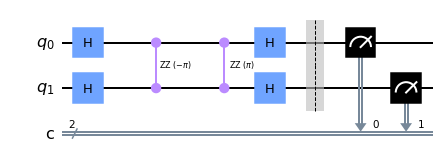

In [66]:
qc1.draw('mpl')

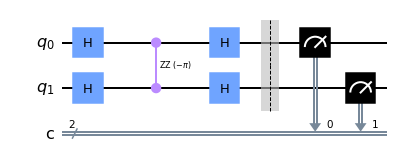

In [67]:
qc2.draw('mpl')

In [70]:
job1 = execute(qc1, backend = backend, shots = 8192)
job2 = execute(qc2, backend = backend, shots = 8192)

results1 = job1.result()
counts1 = results1.get_counts()

results2 = job2.result()
counts2 = results2.get_counts()

In [71]:
%matplotlib inline

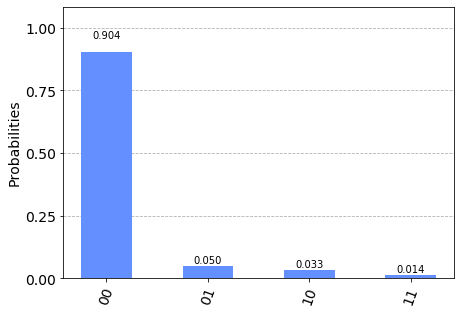

In [72]:
plot_histogram(counts1)

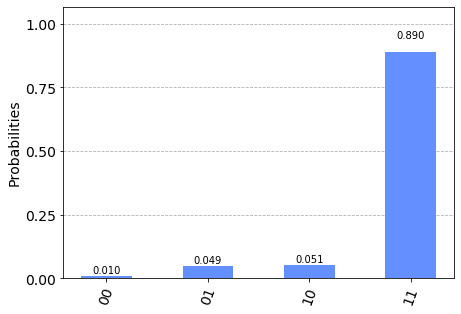

In [73]:
plot_histogram(counts2)